<a href="https://colab.research.google.com/github/mz-zarei/TimeSeriesAnalysis/blob/main/PedestrianFlowForecasting/PedCrossVolumeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Imports

In [26]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display
import os

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.1f}'.format
%matplotlib inline

# 1. Read Data

In [42]:
# Read and transform the data
def load_transform(path_to_data, verbos=False):
    df_all = pd.read_csv(path_to_data, delimiter=';')
    ## Combine date/time columns and change the type to datetime 
    df_all['date'] = pd.to_datetime(df_all['date'] + ' ' + df_all['time'], format='%Y-%m-%d %H:%M:%S')
    ## Set index as date column and sort
    df_all.set_index('date', inplace=True)
    df_all.sort_index(inplace=True)
    ## Drop unused columns
    df_all.drop(columns=['latitude', 'longitude', 'time'], inplace=True)

    if verbos:
        # Show the date range
        print(f'Data From {df_all.index.min()} to {df_all.index.max()}')
        # Show first 10 rows
        display(df_all.head())
        # Show unique intersections names
        print(df_all.name.unique())
    return df_all


path_to_data = './data/20180525-20200416-Milton-Ped-Volume-Per-Crosswalk.csv'
df_all = load_transform(path_to_data, verbos=True)

Data From 2018-05-25 15:00:00 to 2020-04-16 23:45:00


,id,name,vol_vehicle,ped_N,ped_S,ped_E,ped_W
date,,,,,,,
2018-05-25 15:00:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,351,0,0,0,0
2018-05-25 15:15:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,597,0,0,0,0
2018-05-25 15:30:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,612,0,0,0,0
2018-05-25 15:45:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,702,0,0,0,0
2018-05-25 16:00:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,639,0,0,0,0


['Thompson Road and McCuaig Drive' 'Thompson Road and Nipissing Road'
 'James Snow Parkway and Derry Road' 'Thompson Road and Laurier Avenue'
 'Thompson Road and Main Street' 'Ontario Street South and Childs Drive'
 'Ontario Street South and Pine Street'
 'Main Street East and Ontario Street North'
 'Main Street East and Mall Entrance'
 'Bronte Street North and Main Street West'
 'Martin Street and Main Street East' 'Main Street and Sherwood'
 'Laurier Avenue and Ontario Street South'
 'Louis St Laurent Avenue and Commercial Plaza'
 'Thompson Road and Drew Centre'
 'Louis St Laurent Avenue and Farmstead Drive'
 'Main Street E and Harris / Pearson'
 'Main Street East and Leisure Centre Driveway'
 'Main Street East and Maple / Sinclair' 'Fifth Line and Yukon Court'
 'Thompson Road North and Maple Avenue'
 'Thompson Road North and Woodward Avenue'
 'Steeles Avenue East and Martin Street'
 'Main Street West and Scott Boulevard']


# 3. EDA

In [81]:
def get_df_intersection(df_all, int_name):
    # choose one/more intersection
    df = df_all[df_all['name'] == int_name]
    # keep data after 2019-01-01 befor 2020-01-01
    df = df[(df.index >= "2019-01-01") & (df.index < "2020-01-01")]
    return df

# Summary statistics
int_name = 'Ontario Street South and Pine Street'
df_int = get_df_intersection(df_all, int_name)
df_int.describe()

,vol_vehicle,ped_N,ped_S,ped_E,ped_W
count,"34,994.0","34,994.0","34,994.0","34,994.0","34,994.0"
mean,265.5,0.8,0.3,0.5,0.4
std,190.1,1.5,0.6,1.2,0.8
min,2.0,0.0,0.0,0.0,0.0
25%,65.0,0.0,0.0,0.0,0.0
50%,280.0,0.0,0.0,0.0,0.0
75%,427.0,1.0,0.0,1.0,1.0
max,733.0,38.0,22.0,83.0,32.0


,vol_vehicle,ped_N,ped_S,ped_E,ped_W
count,365.0,365.0,365.0,365.0,365.0
mean,"25,457.8",79.1,24.1,45.0,38.4
std,"4,759.2",38.9,10.5,29.7,15.7
min,"7,754.0",10.0,2.0,0.0,5.0
25%,"22,680.0",58.0,17.0,27.0,27.0
50%,"27,586.0",78.0,23.0,47.0,38.0
75%,"28,853.0",96.0,29.0,65.0,47.0
max,"32,421.0",441.0,81.0,287.0,107.0


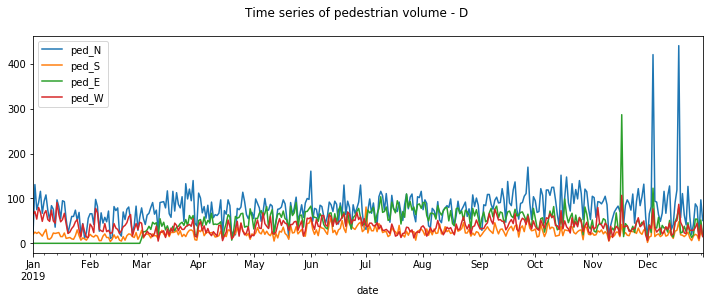

In [82]:
def plot_ts(df_int, agg_level = 'D', show_stat=False):
    # Resample data to get daily or weekly or monthly counts
    df_int_r = df_int.resample(agg_level).sum()

    # Check for duplicate index values
    # print('Duplicate dates in our data (before): ', df_int_r.index.duplicated().sum())

    # Summary statistics
    if show_stat:
        display(df_int_r.describe())

    # Plotting the time series of Ped counts for each crossing
    fig, axs = plt.subplots(1, figsize=(12, 4))
    fig.suptitle('Time series of pedestrian volume - ' + agg_level)

    df_int_r.ped_N.plot(ax=axs)
    df_int_r.ped_S.plot(ax=axs)
    df_int_r.ped_E.plot(ax=axs)
    df_int_r.ped_W.plot(ax=axs)
    axs.legend()
    plt.show()

plot_ts(df_int, show_stat=True)

# 4. Compute 24h pedestrian volume

# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 1
# of flagged rows with F4 (more than H24): 0
# of valid 24h volumes:  364


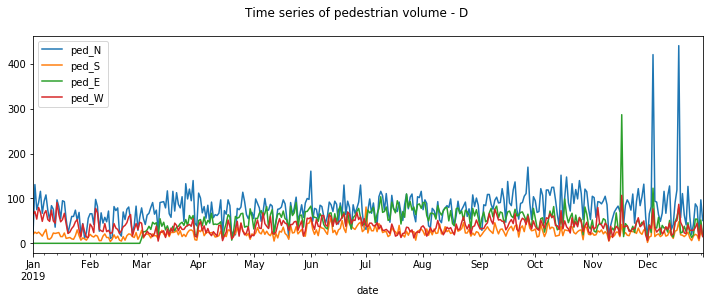

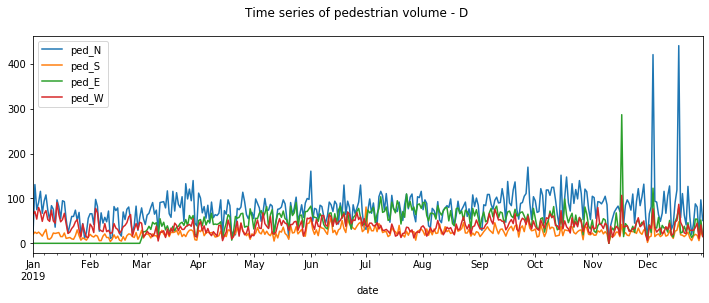

In [104]:
def get_24h_count(df_int, H15=100, H24=500, T24=72):
    # F1: flag rows with all counts equalt to zero as missing values
    columns = ['ped_N', 'ped_S', 'ped_W', 'ped_E', 'vol_vehicle']
    df_int['F1'] = (df_int[columns]==0).all(axis=1)
    print(f"# of flagged rows with F1 (missing): {df_int.F1.sum()}")

    # F2: flag rows with any 15min count greater than H15 on crossing, hard-cap filter 
    columns = ['ped_N', 'ped_S', 'ped_W', 'ped_E']
    df_int['F2'] = (df_int[columns]>H15).any(axis=1)
    print(f"# of flagged rows with F2 (more than H15): {df_int.F2.sum()}")

    # Compute 24h volume on each crossing
    df_int_24h = df_int[(df_int.F1==False) & (df_int.F2==False)].copy()
    df_int_24h = df_int.resample('D').sum()
    df_int_24h['num_valid_counts'] = df_int.vol_vehicle.resample('D').count()

    # Adjust the aggregated counts using factors
    df_int_24h['ped_N'] = df_int_24h.ped_N / df_int_24h.num_valid_counts * 96
    df_int_24h['ped_S'] = df_int_24h.ped_S / df_int_24h.num_valid_counts * 96
    df_int_24h['ped_W'] = df_int_24h.ped_W / df_int_24h.num_valid_counts * 96
    df_int_24h['ped_E'] = df_int_24h.ped_E / df_int_24h.num_valid_counts * 96

    # F3: flag rows with valid 24h volume estimate considering T24
    df_int_24h['F3'] = (df_int_24h['num_valid_counts']<T24)
    print(f"# of flagged rows with F3 (less than T24): {df_int_24h.F3.sum()}")

    # F4: flag rows with any 24h volumes greater than H24, hard-cap filter for crossing
    H24 = 500
    df_int_24h['F4'] = (df_int_24h[columns]>H24).any(axis=1)
    print(f"# of flagged rows with F4 (more than H24): {df_int_24h.F4.sum()}")
    return df_int_24h[(df_int_24h.F3==False) & (df_int_24h.F4==False)]

df_int_24h = get_24h_count(df_int, H15=100, H24=500, T24=72) 
print('# of valid 24h volumes: ', len(df_int_24h))

# Plotting the time series of Ped counts for each crossing
plot_ts(df_int, show_stat=False)
plot_ts(df_int_24h, show_stat=False)

# 5. Compute true volume ratio for each approach

In [113]:
def get_AADPT(df_int_24h, count_col='ped_N'):
    # n_j: Number of months-of-year m for which there is at least one valid 24h volume
    # n_jm: Number of days-of-week d in month-of-year m for which there is least one valid 24h volume
    # n_jmd: Number of valid 24h volume for day-of-week d in month-of-year m at location j
    # V_jmdi: 24h volume at location j on the i-th occurrence of day-of-week d in month m
    months = df_int_24h.index.month.unique()
    dayofweeks = df_int_24h.index.dayofweek.unique()
    n_j = len(months)       
    n_jm = len(dayofweeks)
    AADPT = 0
    for m in months:
        for d in dayofweeks:
            volumes = df_int_24h[(df_int_24h.index.month == m) & (df_int_24h.index.dayofweek == d)][count_col].values
            sum_V_jmdi = sum(volumes)
            n_jmd = len(volumes)
            if n_jmd !=0:
                AADPT += 1/n_j * 1/n_jm * 1/n_jmd * sum_V_jmdi
    return AADPT

def get_true_ratio(df_int_24h):
    # average annual daily pedestrian traffic
    AADPT_N = get_AADPT(df_int_24h, 'ped_N')
    AADPT_S = get_AADPT(df_int_24h, 'ped_S')
    AADPT_W = get_AADPT(df_int_24h, 'ped_W')
    AADPT_E = get_AADPT(df_int_24h, 'ped_E')
    AADPT_tot = AADPT_N + AADPT_S + AADPT_W + AADPT_E

    # true volume ratios 
    ratio_N_true = 0 if AADPT_tot==0 else AADPT_N / AADPT_tot 
    ratio_S_true = 0 if AADPT_tot==0 else AADPT_S / AADPT_tot 
    ratio_W_true = 0 if AADPT_tot==0 else AADPT_W / AADPT_tot 
    ratio_E_true = 0 if AADPT_tot==0 else AADPT_E / AADPT_tot 
    return AADPT_tot, ratio_N_true, ratio_S_true, ratio_W_true, ratio_E_true

AADPT, ratio_N_true, ratio_S_true, ratio_W_true, ratio_E_true = get_true_ratio(df_int_24h)

print(f'AADPT: {AADPT}')
print(f'True Ratio N:{ratio_N_true:.{2}f}, S:{ratio_S_true:.{2}f}')
print(f'           W:{ratio_W_true:.{2}f}, E:{ratio_E_true:.{2}f}')

AADPT: 764.7719841269841
True Ratio N:0.33, S:0.13
           W:0.23, E:0.31


# 6. Calculate short-term counts for each approach

In [106]:
def filter_valid_stc(df_int, verbos=False):
    # Resample data to get Hourly counts
    df_int_stc_h = df_int.resample('H').sum()

    # Keep valid hours for short-term count 7am-9am, 11am-2pm, 3pm-6pm
    df_int_stc_h_valid = pd.concat([df_int_stc_h.between_time('7:00', '9:00'),
                                df_int_stc_h.between_time('11:00', '14:00'),
                                df_int_stc_h.between_time('15:00', '18:00')])
    
    # Resample data to get daily short-term counts
    df_int_stc_d_valid = df_int_stc_h_valid.resample('D').sum()

    # Keep valid months (4,5,6,9,10,11) and day of weeks Tuesdays (1), Wednesdays (2), and Thursdays (3)
    df_int_stc_d_valid = df_int_stc_d_valid[df_int_stc_d_valid.index.dayofweek.isin([1,2,3]) & df_int_stc_d_valid.index.month.isin([4,5,6,9,10,11])]
    
    # check if filters worked
    if verbos:
        print('Hours: ', df_int_stc_h_valid.index.hour.unique())
        print('Day of Weeks: ', df_int_stc_d_valid.index.day_of_week.unique())
        print('Months: ', df_int_stc_d_valid.index.month.unique())

    # Exclude the holidays
    holidays = ['2019-01-01','2019-01-02', '2019-01-03', '2019-01-20',
                '2019-02-17', 
                '2019-03-16', '2019-03-17', '2019-03-18', '2019-03-19', '2019-03-20']
    df_int_stc_d_valid = df_int_stc_d_valid[~df_int_stc_d_valid.index.isin(holidays)]
    return df_int_stc_d_valid


df_int_stc_d_valid = filter_valid_stc(df_int)
df_int_stc_d_valid

,vol_vehicle,ped_N,ped_S,ped_E,ped_W,F1,F2
date,,,,,,,
2019-04-02,21347,86,17,43,39,0,0
2019-04-03,20885,50,26,33,27,0,0
2019-04-04,21924,73,12,45,33,0,0
2019-04-09,20759,50,14,36,20,0,0
2019-04-10,21081,56,14,35,18,0,0
...,...,...,...,...,...,...,...
2019-11-20,21201,81,17,32,32,0,0
2019-11-21,20709,78,15,27,25,0,0
2019-11-26,20598,96,26,42,43,0,0


# 7. Calculate volume ratio error from ST counts

In [107]:
def get_ratio_error(df_int_stc_d_valid, df_int_24h):
    # calculate true ratios
    _, ratio_N_true, ratio_S_true, ratio_W_true, ratio_E_true = get_true_ratio(df_int_24h)
    
    # total short term count for each day
    df_int_stc_d_valid['total'] = df_int_stc_d_valid.ped_N + df_int_stc_d_valid.ped_S + df_int_stc_d_valid.ped_W + df_int_stc_d_valid.ped_E

    # drop those days with zero total counts
    print(f'valid STC: {len(df_int_stc_d_valid)}, droped zero counts: {len(df_int_stc_d_valid[df_int_stc_d_valid.total == 0])}')
    df_int_stc_d_valid.drop(df_int_stc_d_valid[df_int_stc_d_valid.total == 0].index, inplace=True)

    # volume ratio for each approach
    df_int_stc_d_valid['ratio_N'] = df_int_stc_d_valid.ped_N / df_int_stc_d_valid.total
    df_int_stc_d_valid['ratio_S'] = df_int_stc_d_valid.ped_S / df_int_stc_d_valid.total
    df_int_stc_d_valid['ratio_W'] = df_int_stc_d_valid.ped_W / df_int_stc_d_valid.total
    df_int_stc_d_valid['ratio_E'] = df_int_stc_d_valid.ped_E / df_int_stc_d_valid.total

    # volume ratio error for each approach
    df_int_stc_d_valid['ratio_N_err'] = (df_int_stc_d_valid.ped_N / df_int_stc_d_valid.total - ratio_N_true)/(ratio_N_true + 0.0001)
    df_int_stc_d_valid['ratio_S_err'] = (df_int_stc_d_valid.ped_S / df_int_stc_d_valid.total - ratio_S_true)/(ratio_S_true + 0.0001)
    df_int_stc_d_valid['ratio_W_err'] = (df_int_stc_d_valid.ped_W / df_int_stc_d_valid.total - ratio_W_true)/(ratio_W_true + 0.0001)
    df_int_stc_d_valid['ratio_E_err'] = (df_int_stc_d_valid.ped_E / df_int_stc_d_valid.total - ratio_E_true)/(ratio_E_true + 0.0001)

    df_int_stc_d_valid['ratio_err_avg'] = 0.25*(abs(df_int_stc_d_valid['ratio_E_err'])+abs(df_int_stc_d_valid['ratio_W_err'])+
                                        abs(df_int_stc_d_valid['ratio_N_err'])+abs(df_int_stc_d_valid['ratio_N_err']))
    return df_int_stc_d_valid

df_int_stc_d_valid = get_ratio_error(df_int_stc_d_valid, df_int_24h)
df_int_stc_d_valid.head()


valid STC: 78, droped zero counts: 0


,vol_vehicle,ped_N,ped_S,ped_E,ped_W,F1,F2,total,ratio_N,ratio_S,ratio_W,ratio_E,ratio_N_err,ratio_S_err,ratio_W_err,ratio_E_err,ratio_err_avg
date,,,,,,,,,,,,,,,,,
2019-04-02,21347,86,17,43,39,0,0,185,0.5,0.1,0.2,0.2,0.1,-0.3,0.0,-0.0,0.1
2019-04-03,20885,50,26,33,27,0,0,136,0.4,0.2,0.2,0.2,-0.1,0.5,-0.0,0.0,0.1
2019-04-04,21924,73,12,45,33,0,0,163,0.4,0.1,0.2,0.3,0.1,-0.4,-0.0,0.1,0.1
2019-04-09,20759,50,14,36,20,0,0,120,0.4,0.1,0.2,0.3,-0.0,-0.1,-0.2,0.2,0.1
2019-04-10,21081,56,14,35,18,0,0,123,0.5,0.1,0.1,0.3,0.1,-0.1,-0.3,0.2,0.2


95% CI for ratio_N_err: (-0.38, 0.02, 0.42)
95% CI for ratio_S_err: (-0.43, -0.08, 0.28)
95% CI for ratio_W_err: (-0.57, -0.09, 0.39)
95% CI for ratio_E_err: (-0.38, 0.12, 0.62)


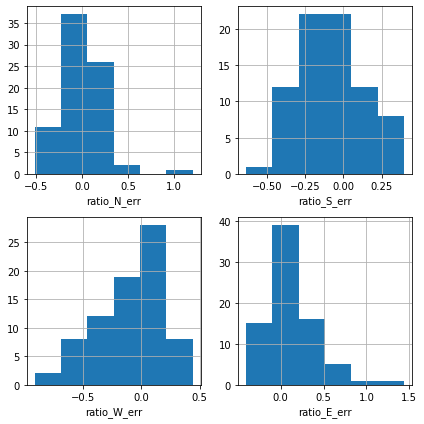

Text(0.5, 1.0, 'AVG volume ratio error')

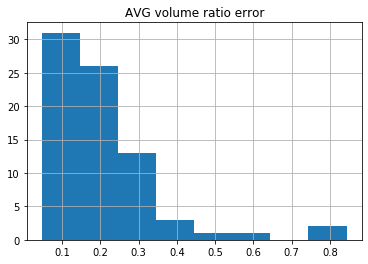

In [119]:
# returns lower and upper bound of 95% CI for given column assuming normal dist
def confidence_interval(df, col):
    mean = df[col].mean()
    sd = df[col].std()
    n = len(df)
    Zstar=1.65

    lcb = mean - Zstar * sd
    ucb = mean + Zstar * sd
    
    return round(lcb,2), round(mean,2), round(ucb,2)
    
# Plot the dist of the errors and 95% CI
fig, axes = plt.subplots(2,2, figsize=(6,6))
for ax, col in [(axes[0,0],'ratio_N_err'),(axes[0,1],'ratio_S_err'),
                (axes[1,0],'ratio_W_err'),(axes[1,1],'ratio_E_err')]:
    df_int_stc_d_valid[col].hist(ax=ax, bins=6)
    ax.set_xlabel(col)
    print(f'95% CI for {col}: {confidence_interval(df_int_stc_d_valid, col)}')

plt.tight_layout()
plt.show()

df_int_stc_d_valid['ratio_err_avg'].hist(bins=8) 
plt.title('AVG volume ratio error')   

True ratios: N:0.42, S:0.13, W:0.21, E:0.24


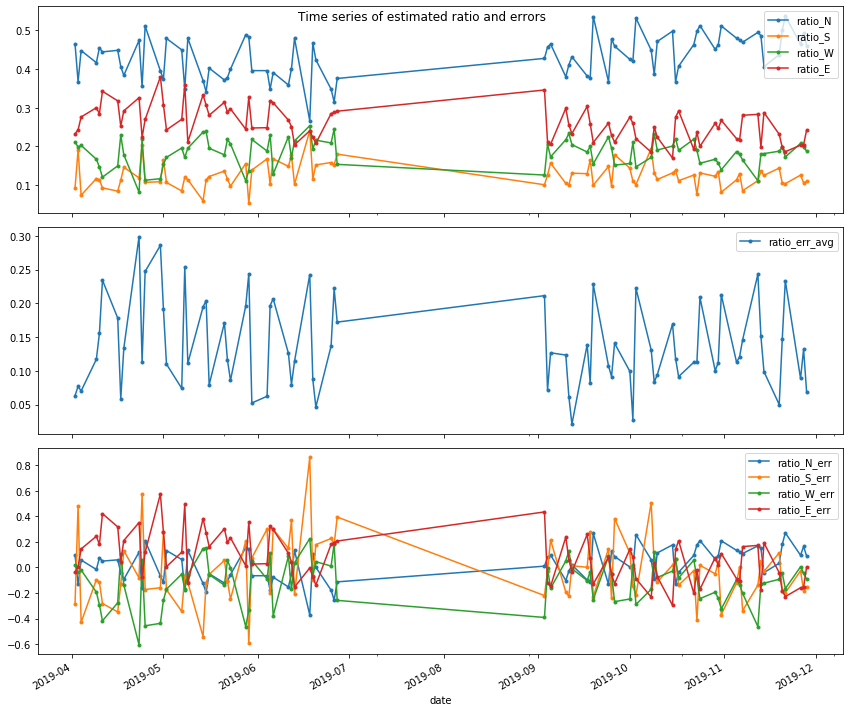

In [109]:
def plot_ts_ratio_err(df_int_stc_d_valid, df_int_24h):
    # Plotting the time series of estimated ratio for each crossing
    fig, axs = plt.subplots(3,1, figsize=(12, 10), sharex=True)
    fig.suptitle('Time series of estimated ratio and errors')

    # calculate true ratios
    _, ratio_N_true, ratio_S_true, ratio_W_true, ratio_E_true = get_true_ratio(df_int_24h)
    print(f'True ratios: N:{ratio_N_true:.{2}f}, S:{ratio_S_true:.{2}f}, W:{ratio_W_true:.{2}f}, E:{ratio_E_true:.{2}f}')

    df_int_stc_d_valid.ratio_N.plot(ax=axs[0], style='.-')
    df_int_stc_d_valid.ratio_S.plot(ax=axs[0], style='.-')
    df_int_stc_d_valid.ratio_W.plot(ax=axs[0], style='.-')
    df_int_stc_d_valid.ratio_E.plot(ax=axs[0], style='.-')

    df_int_stc_d_valid.ratio_err_avg.plot(ax=axs[1], style='.-')

    df_int_stc_d_valid.ratio_N_err.plot(ax=axs[2], style='.-')
    df_int_stc_d_valid.ratio_S_err.plot(ax=axs[2], style='.-')
    df_int_stc_d_valid.ratio_W_err.plot(ax=axs[2], style='.-')
    df_int_stc_d_valid.ratio_E_err.plot(ax=axs[2], style='.-')

    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')
    axs[2].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_ts_ratio_err(df_int_stc_d_valid, df_int_24h)

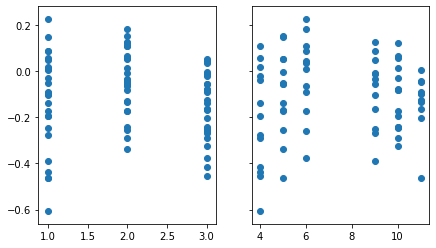

In [110]:
# ratio error distributions for different days of week and months
fig, ax = plt.subplots(1,2, figsize=(7,4), sharey=True)
ax[0].scatter(df_int_stc_d_valid.index.dayofweek, df_int_stc_d_valid.ratio_W_err)
ax[1].scatter(df_int_stc_d_valid.index.month    , df_int_stc_d_valid.ratio_W_err)

# 7. Plot ratio errors for all intersections

Thompson Road and McCuaig Drive
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 16
# of flagged rows with F4 (more than H24): 0
valid STC: 78, droped zero counts: 78
Thompson Road and Nipissing Road
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 55
# of flagged rows with F4 (more than H24): 0
valid STC: 78, droped zero counts: 22
95% estimate error for ratio on ratio_N_err: (0.0, 0.0, 0.0)
95% estimate error for ratio on ratio_S_err: (-0.55, 0.19, 0.93)
95% estimate error for ratio on ratio_W_err: (-0.07, -0.01, 0.04)
95% estimate error for ratio on ratio_E_err: (0.0, 0.0, 0.0)
95% estimate error for ratio on ratio_err_avg: (-0.0, 0.01, 0.02)
True ratios: N:0.00, S:0.07, W:0.93, E:0.00


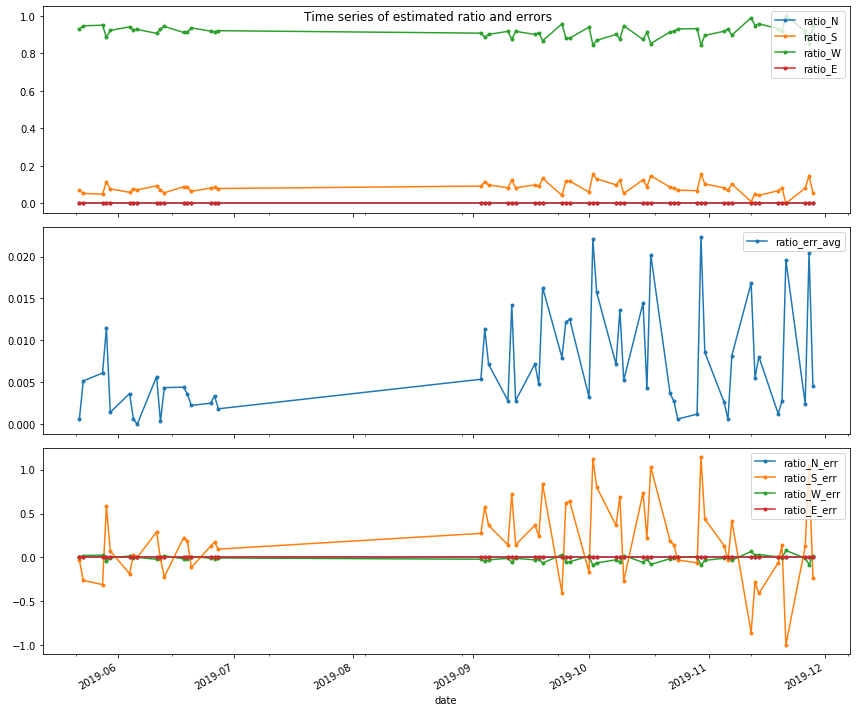

James Snow Parkway and Derry Road
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 2
# of flagged rows with F4 (more than H24): 0
valid STC: 69, droped zero counts: 0
95% estimate error for ratio on ratio_N_err: (-1.25, -0.19, 0.87)
95% estimate error for ratio on ratio_S_err: (-1.24, 0.33, 1.9)
95% estimate error for ratio on ratio_W_err: (-0.58, -0.03, 0.52)
95% estimate error for ratio on ratio_E_err: (-2.25, 0.19, 2.63)
95% estimate error for ratio on ratio_err_avg: (-0.0, 0.61, 1.22)
True ratios: N:0.21, S:0.14, W:0.59, E:0.06


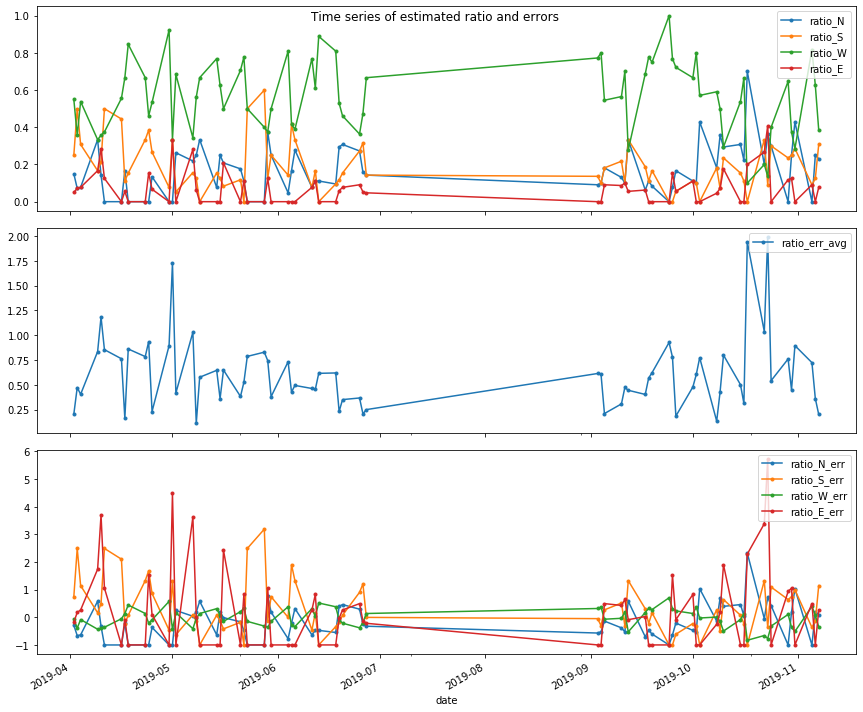

Thompson Road and Laurier Avenue
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 4
# of flagged rows with F4 (more than H24): 0
valid STC: 78, droped zero counts: 1
95% estimate error for ratio on ratio_N_err: (-0.38, 0.02, 0.42)
95% estimate error for ratio on ratio_S_err: (-0.43, -0.08, 0.28)
95% estimate error for ratio on ratio_W_err: (-0.57, -0.09, 0.39)
95% estimate error for ratio on ratio_E_err: (-0.38, 0.12, 0.62)
95% estimate error for ratio on ratio_err_avg: (-0.03, 0.2, 0.44)
True ratios: N:0.20, S:0.15, W:0.33, E:0.32


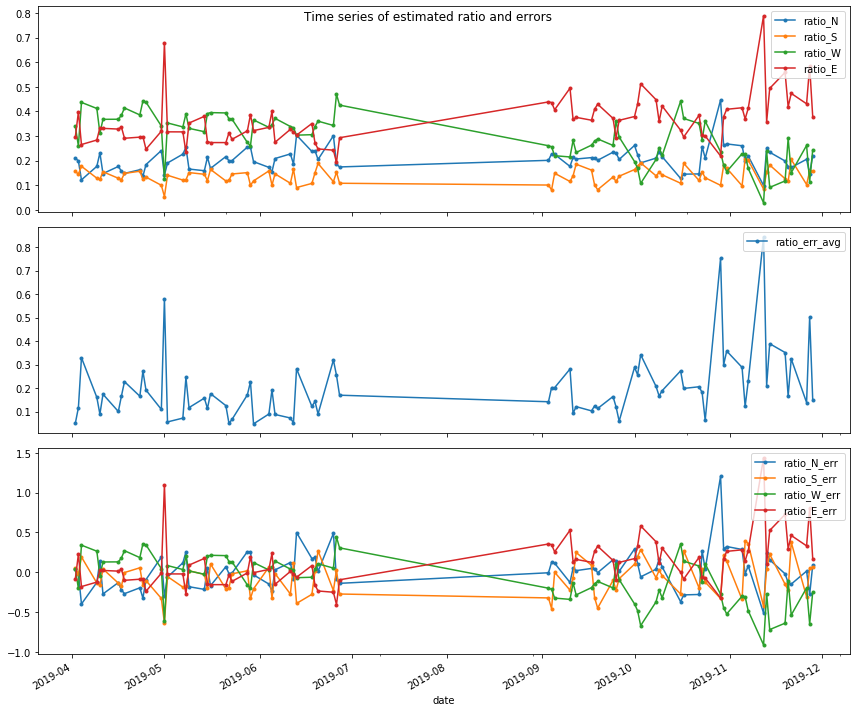

Thompson Road and Main Street
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 54
# of flagged rows with F4 (more than H24): 8
valid STC: 78, droped zero counts: 22
95% estimate error for ratio on ratio_N_err: (-0.29, 0.03, 0.34)
95% estimate error for ratio on ratio_S_err: (-0.33, 0.1, 0.54)
95% estimate error for ratio on ratio_W_err: (-0.2, -0.06, 0.09)
95% estimate error for ratio on ratio_E_err: (-0.46, -0.11, 0.25)
95% estimate error for ratio on ratio_err_avg: (0.02, 0.14, 0.26)
True ratios: N:0.19, S:0.32, W:0.27, E:0.22


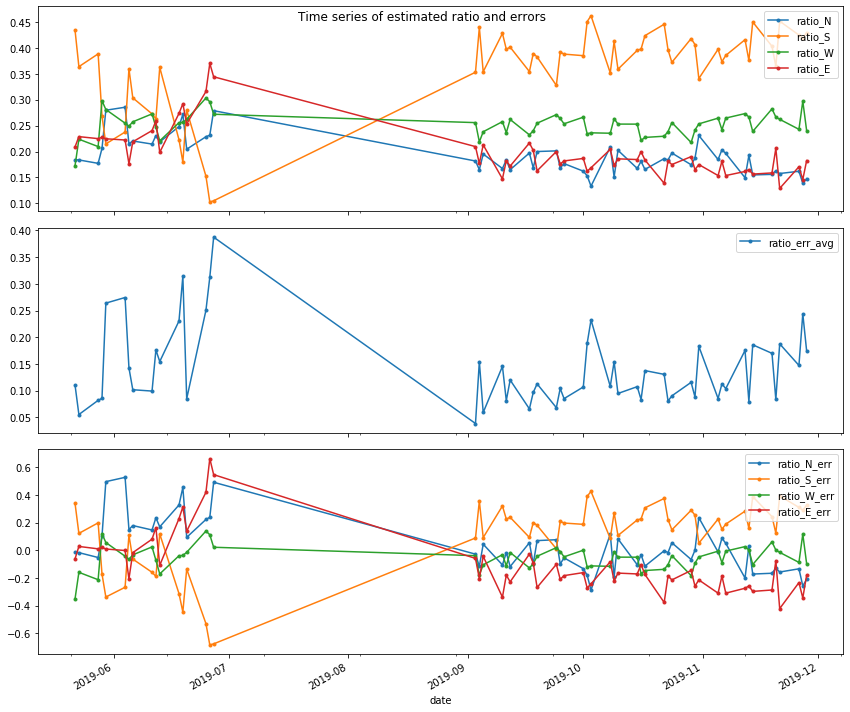

Ontario Street South and Childs Drive
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 0
# of flagged rows with F4 (more than H24): 0
valid STC: 78, droped zero counts: 0
95% estimate error for ratio on ratio_N_err: (-0.58, -0.1, 0.38)
95% estimate error for ratio on ratio_S_err: (-0.85, -0.04, 0.78)
95% estimate error for ratio on ratio_W_err: (-0.33, 0.05, 0.42)
95% estimate error for ratio on ratio_E_err: (-0.22, 0.03, 0.27)
95% estimate error for ratio on ratio_err_avg: (0.04, 0.21, 0.37)
True ratios: N:0.20, S:0.11, W:0.25, E:0.43


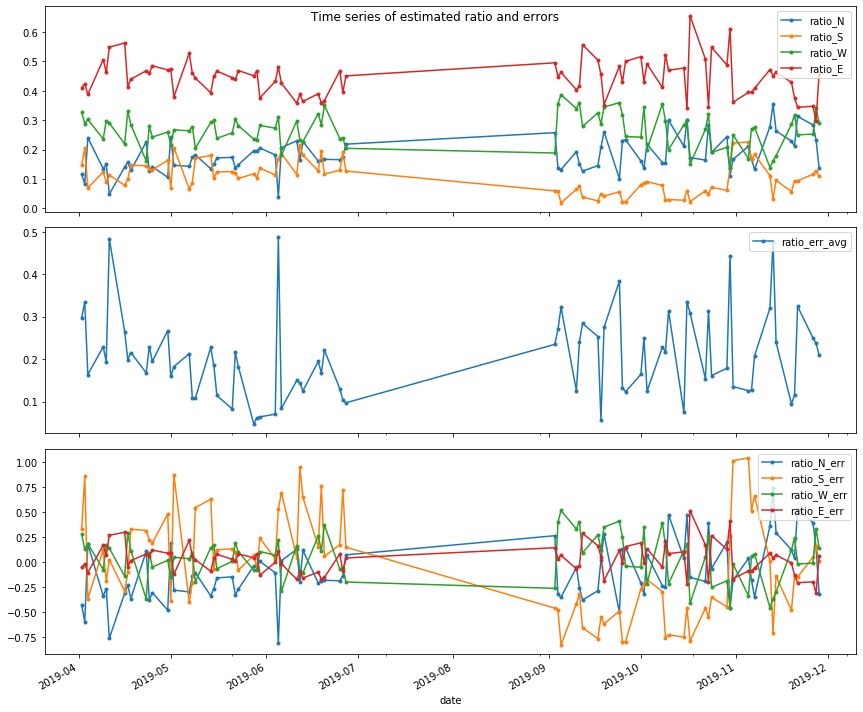

Ontario Street South and Pine Street
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 1
# of flagged rows with F4 (more than H24): 0
valid STC: 78, droped zero counts: 0
95% estimate error for ratio on ratio_N_err: (-0.2, 0.02, 0.24)
95% estimate error for ratio on ratio_S_err: (-0.45, -0.03, 0.4)
95% estimate error for ratio on ratio_W_err: (-0.4, -0.11, 0.18)
95% estimate error for ratio on ratio_E_err: (-0.24, 0.08, 0.39)
95% estimate error for ratio on ratio_err_avg: (0.03, 0.14, 0.24)
True ratios: N:0.42, S:0.13, W:0.21, E:0.24


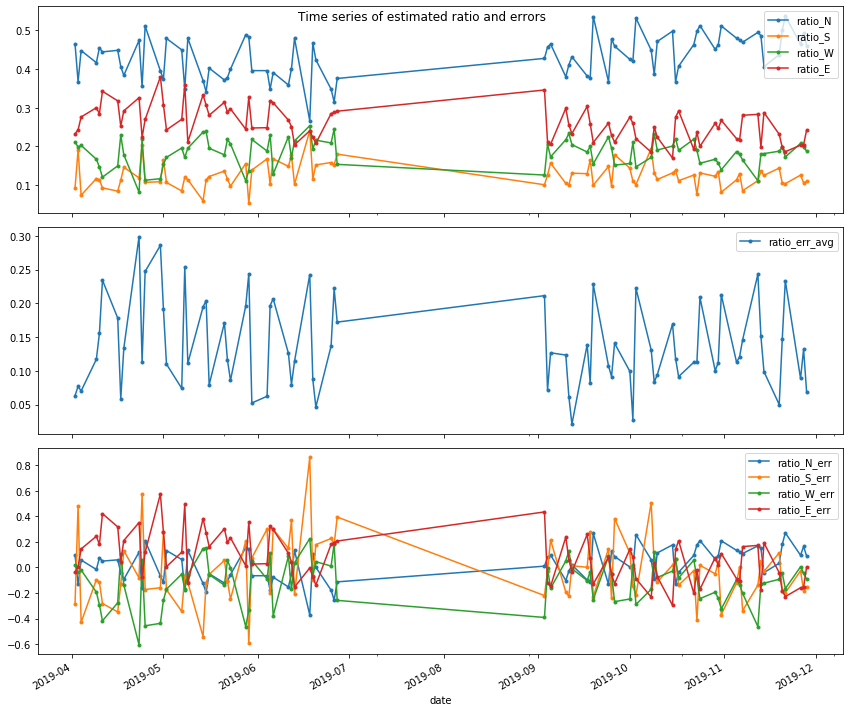

Main Street East and Ontario Street North
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 0
# of flagged rows with F4 (more than H24): 2
valid STC: 78, droped zero counts: 0
95% estimate error for ratio on ratio_N_err: (-0.23, -0.01, 0.21)
95% estimate error for ratio on ratio_S_err: (-0.25, -0.08, 0.09)
95% estimate error for ratio on ratio_W_err: (-0.17, 0.08, 0.33)
95% estimate error for ratio on ratio_E_err: (-0.18, 0.04, 0.26)
95% estimate error for ratio on ratio_err_avg: (0.03, 0.12, 0.2)
True ratios: N:0.24, S:0.31, W:0.20, E:0.25


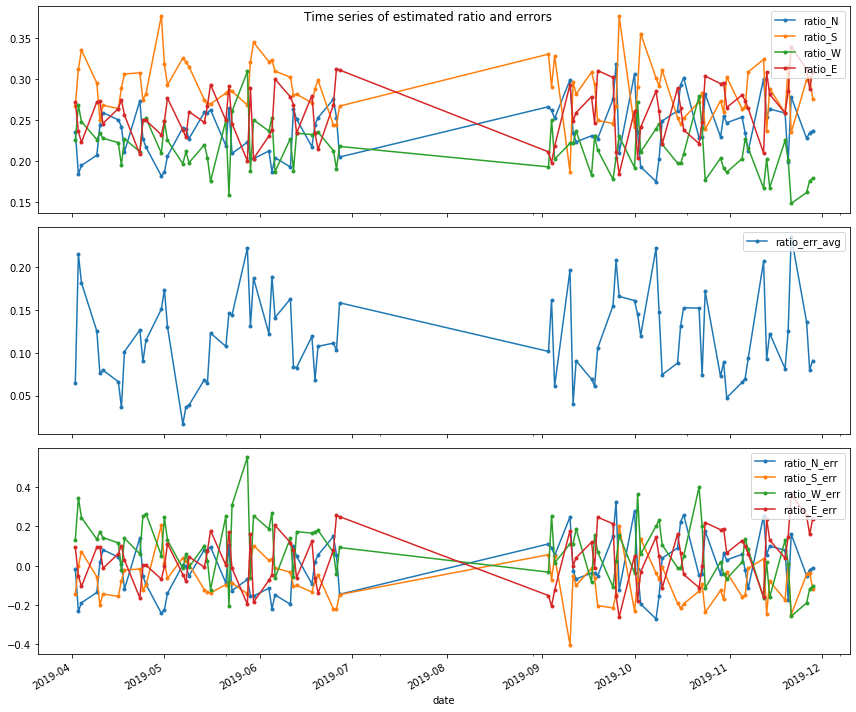

Main Street East and Mall Entrance
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 0
# of flagged rows with F4 (more than H24): 1
valid STC: 78, droped zero counts: 0
95% estimate error for ratio on ratio_N_err: (0.0, 0.0, 0.0)
95% estimate error for ratio on ratio_S_err: (-0.3, -0.13, 0.05)
95% estimate error for ratio on ratio_W_err: (0.0, 0.0, 0.0)
95% estimate error for ratio on ratio_E_err: (-0.12, 0.3, 0.71)
95% estimate error for ratio on ratio_err_avg: (-0.0, 0.08, 0.17)
True ratios: N:0.00, S:0.70, W:0.00, E:0.30


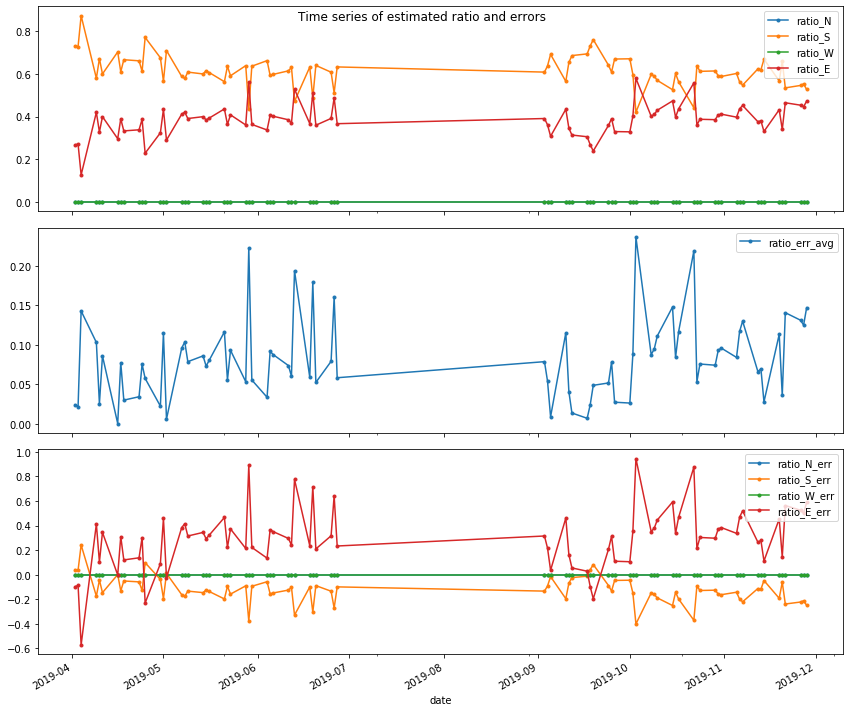

Bronte Street North and Main Street West
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 1
# of flagged rows with F3 (less than T24): 6
# of flagged rows with F4 (more than H24): 2
valid STC: 78, droped zero counts: 0
95% estimate error for ratio on ratio_N_err: (-0.83, 0.12, 1.07)
95% estimate error for ratio on ratio_S_err: (-0.55, -0.15, 0.25)
95% estimate error for ratio on ratio_W_err: (-1.18, 0.34, 1.86)
95% estimate error for ratio on ratio_E_err: (-0.57, 0.15, 0.87)
95% estimate error for ratio on ratio_err_avg: (-0.14, 0.43, 1.0)
True ratios: N:0.11, S:0.56, W:0.09, E:0.24


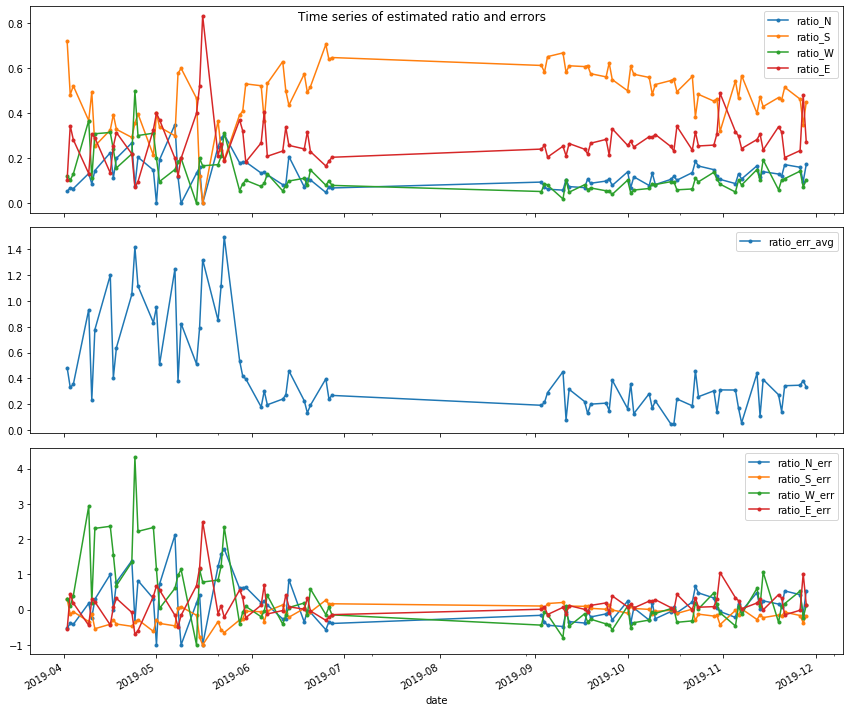

Martin Street and Main Street East
# of flagged rows with F1 (missing): 10
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 1
# of flagged rows with F4 (more than H24): 0
valid STC: 56, droped zero counts: 56
Main Street and Sherwood
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 5
# of flagged rows with F4 (more than H24): 0
valid STC: 51, droped zero counts: 51
Laurier Avenue and Ontario Street South
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 10
# of flagged rows with F4 (more than H24): 0
valid STC: 45, droped zero counts: 0
95% estimate error for ratio on ratio_N_err: (-0.16, 0.08, 0.32)
95% estimate error for ratio on ratio_S_err: (-0.13, 0.09, 0.31)
95% estimate error for ratio on ratio_W_err: (-0.52, -0.23, 0.07)
95% estimate error for ratio on ratio_E_err: (-0.33, -0.08, 0.17)
9

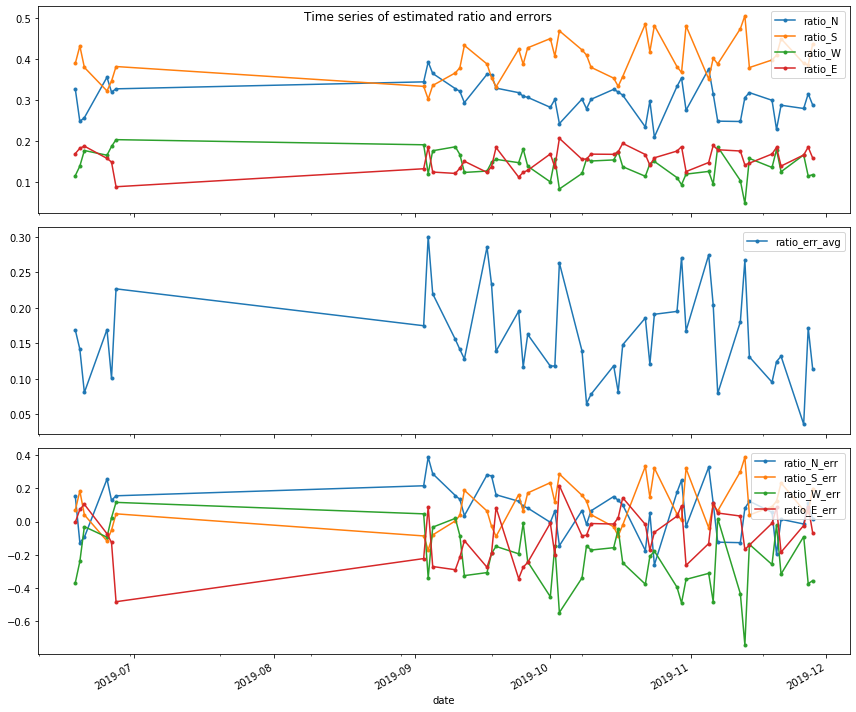

Louis St Laurent Avenue and Commercial Plaza
# of flagged rows with F1 (missing): 1
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 2
# of flagged rows with F4 (more than H24): 0
valid STC: 39, droped zero counts: 5
95% estimate error for ratio on ratio_N_err: (0.0, 0.0, 0.0)
95% estimate error for ratio on ratio_S_err: (0.0, 0.0, 0.0)
95% estimate error for ratio on ratio_W_err: (-1.14, -0.09, 0.95)
95% estimate error for ratio on ratio_E_err: (-1.17, 0.12, 1.41)
95% estimate error for ratio on ratio_err_avg: (-0.02, 0.3, 0.61)
True ratios: N:0.00, S:0.00, W:0.55, E:0.45


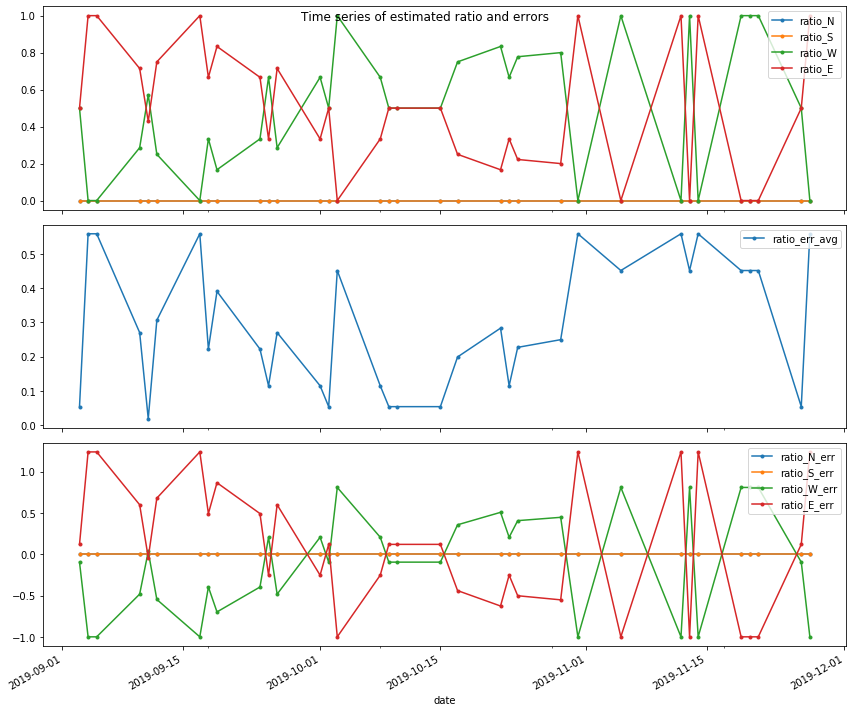

Thompson Road and Drew Centre
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 19
# of flagged rows with F3 (less than T24): 1
# of flagged rows with F4 (more than H24): 13
valid STC: 39, droped zero counts: 0
95% estimate error for ratio on ratio_N_err: (-0.17, 0.04, 0.24)
95% estimate error for ratio on ratio_S_err: (-0.06, 0.19, 0.44)
95% estimate error for ratio on ratio_W_err: (-0.37, -0.19, -0.01)
95% estimate error for ratio on ratio_E_err: (-0.14, 0.03, 0.2)
95% estimate error for ratio on ratio_err_avg: (0.02, 0.12, 0.22)
True ratios: N:0.33, S:0.13, W:0.23, E:0.31


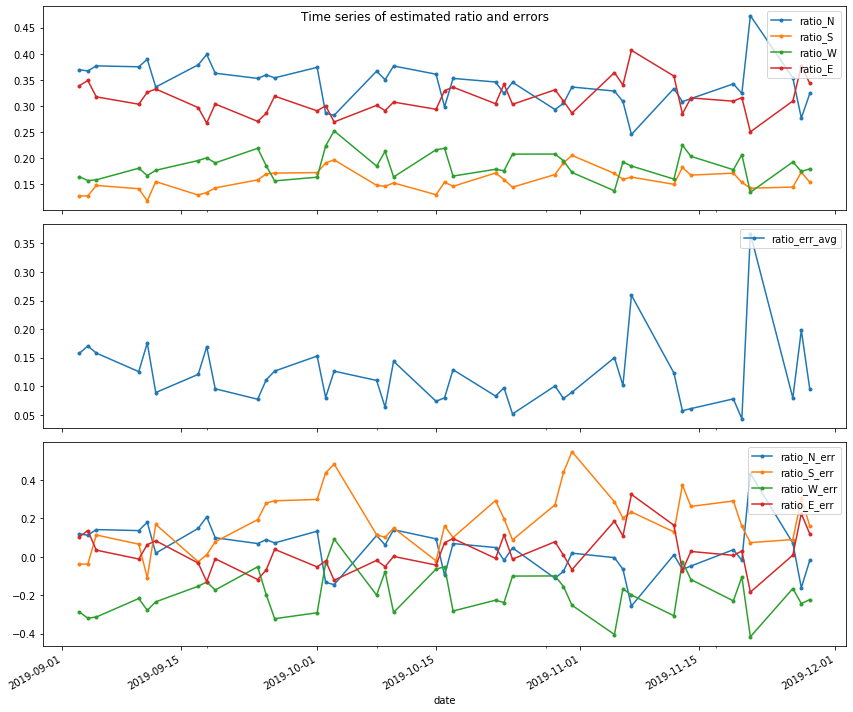

Louis St Laurent Avenue and Farmstead Drive
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 42
# of flagged rows with F3 (less than T24): 2
# of flagged rows with F4 (more than H24): 3
valid STC: 39, droped zero counts: 0
95% estimate error for ratio on ratio_N_err: (-0.33, -0.15, 0.02)
95% estimate error for ratio on ratio_S_err: (-0.2, 0.04, 0.28)
95% estimate error for ratio on ratio_W_err: (-0.08, 0.09, 0.27)
95% estimate error for ratio on ratio_E_err: (-0.39, -0.11, 0.17)
95% estimate error for ratio on ratio_err_avg: (0.05, 0.15, 0.25)
True ratios: N:0.23, S:0.26, W:0.40, E:0.11


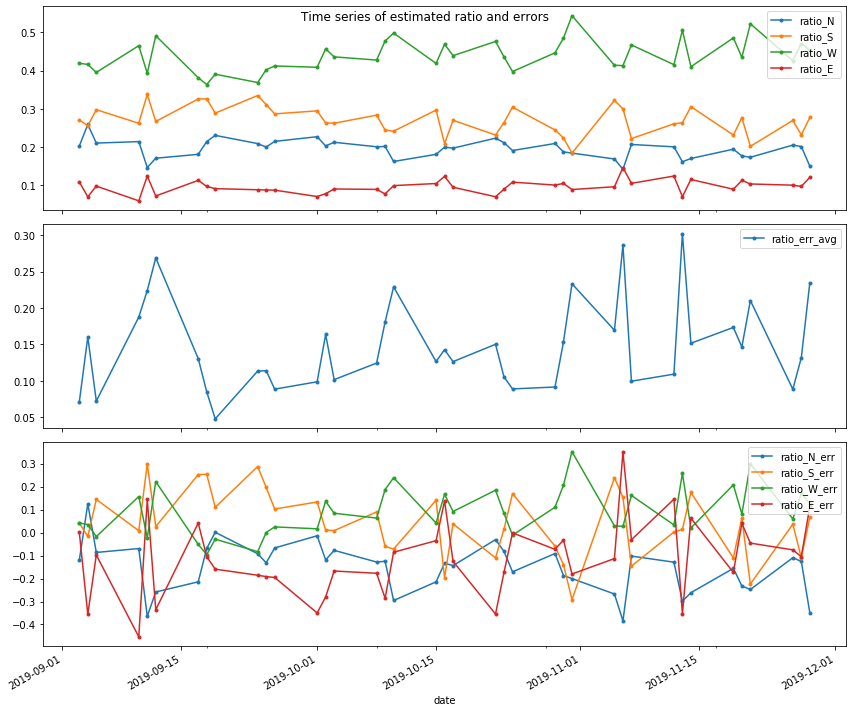

Main Street E and Harris / Pearson
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 1
# of flagged rows with F4 (more than H24): 0
valid STC: 20, droped zero counts: 0
95% estimate error for ratio on ratio_N_err: (-0.69, -0.04, 0.62)
95% estimate error for ratio on ratio_S_err: (-0.49, -0.13, 0.22)
95% estimate error for ratio on ratio_W_err: (-0.24, 0.03, 0.31)
95% estimate error for ratio on ratio_E_err: (-0.15, 0.08, 0.31)
95% estimate error for ratio on ratio_err_avg: (-0.21, 0.16, 0.53)
True ratios: N:0.12, S:0.23, W:0.34, E:0.30


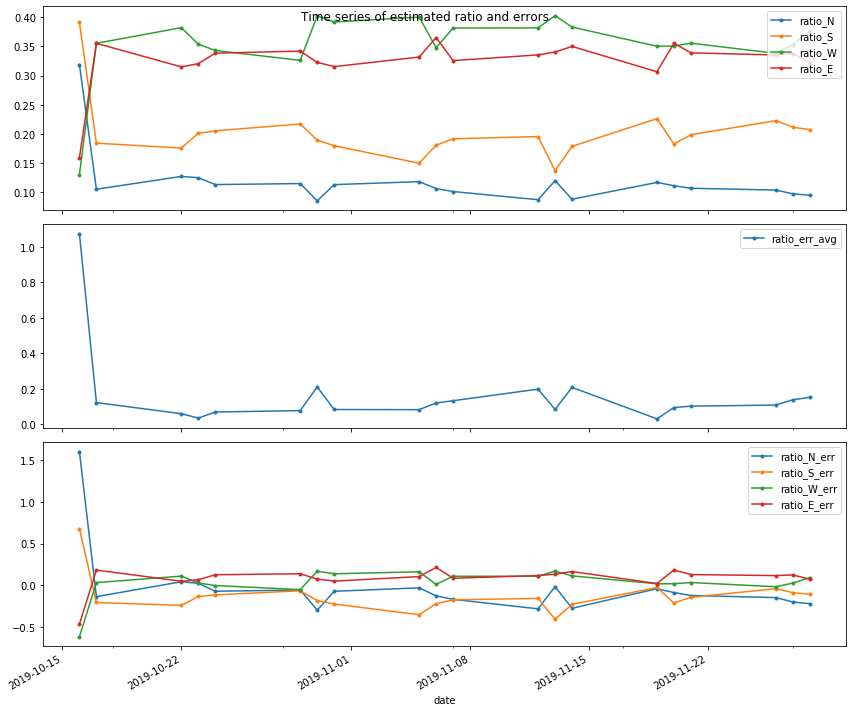

Main Street East and Leisure Centre Driveway
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 1
# of flagged rows with F4 (more than H24): 0
valid STC: 15, droped zero counts: 0
95% estimate error for ratio on ratio_N_err: (0.0, 0.0, 0.0)
95% estimate error for ratio on ratio_S_err: (-0.15, -0.05, 0.06)
95% estimate error for ratio on ratio_W_err: (-0.43, -0.03, 0.37)
95% estimate error for ratio on ratio_E_err: (-0.08, 0.14, 0.35)
95% estimate error for ratio on ratio_err_avg: (0.02, 0.09, 0.15)
True ratios: N:0.00, S:0.63, W:0.12, E:0.25


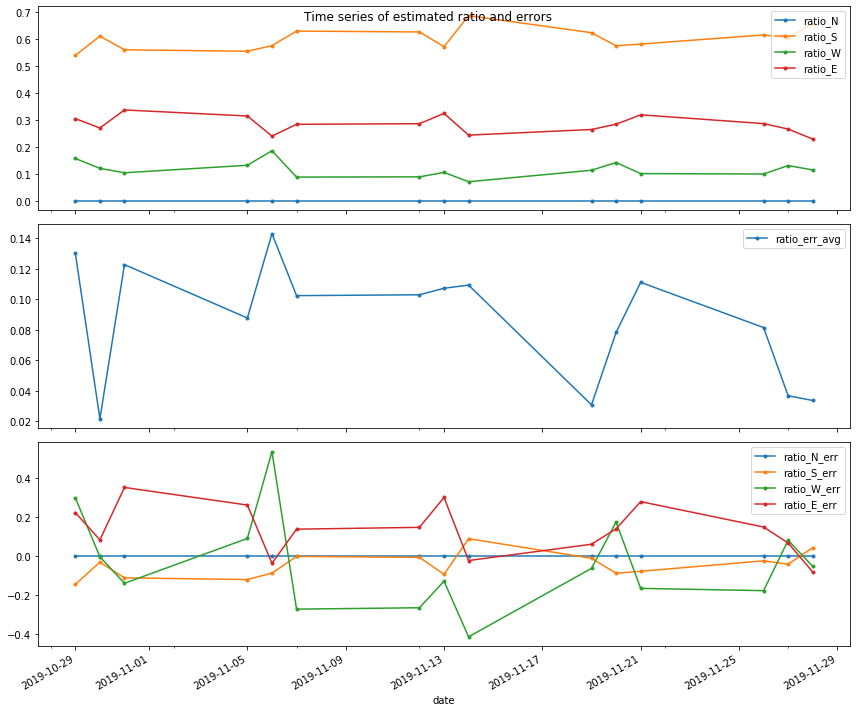

Main Street East and Maple / Sinclair
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 2
# of flagged rows with F4 (more than H24): 0
valid STC: 12, droped zero counts: 0
95% estimate error for ratio on ratio_N_err: (-0.33, -0.01, 0.31)
95% estimate error for ratio on ratio_S_err: (-0.23, -0.02, 0.2)
95% estimate error for ratio on ratio_W_err: (-0.34, 0.14, 0.61)
95% estimate error for ratio on ratio_E_err: (-0.36, -0.08, 0.21)
95% estimate error for ratio on ratio_err_avg: (0.01, 0.16, 0.32)
True ratios: N:0.32, S:0.33, W:0.16, E:0.18


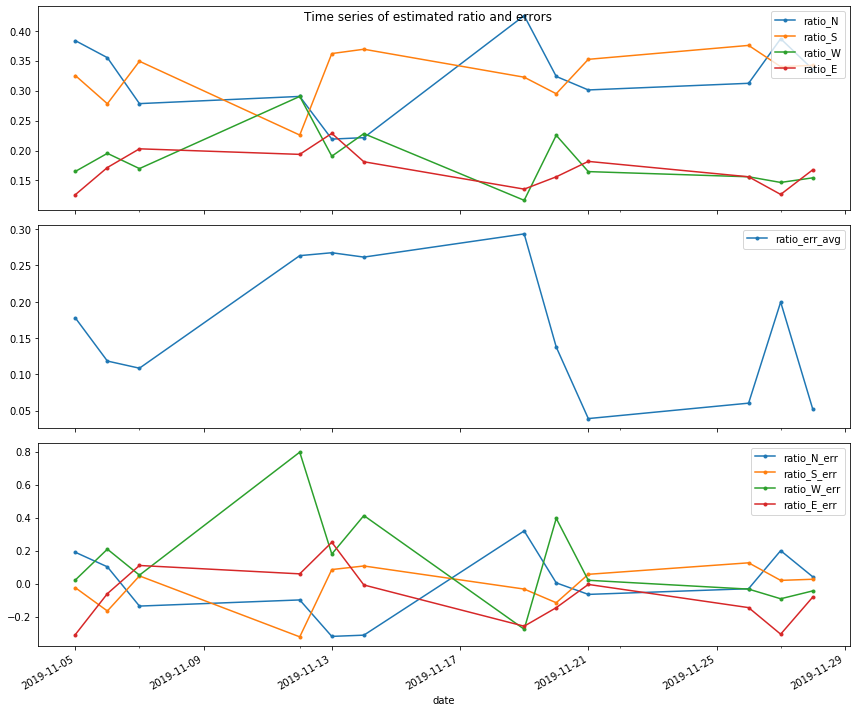

Fifth Line and Yukon Court
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 1
# of flagged rows with F4 (more than H24): 0
valid STC: 8, droped zero counts: 8
Thompson Road North and Maple Avenue
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 0
# of flagged rows with F4 (more than H24): 0
valid STC: 0, droped zero counts: 0
Thompson Road North and Woodward Avenue
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 0
# of flagged rows with F4 (more than H24): 0
valid STC: 0, droped zero counts: 0
Steeles Avenue East and Martin Street
# of flagged rows with F1 (missing): 0
# of flagged rows with F2 (more than H15): 0
# of flagged rows with F3 (less than T24): 0
# of flagged rows with F4 (more than H24): 0
valid STC: 0, droped zero counts: 0
Main Street West a

In [120]:
# plot ratio error time series for all intersections
path_to_data = './data/20180525-20200416-Milton-Ped-Volume-Per-Crosswalk.csv'
df_all = load_transform(path_to_data)
int_list = df_all.name.unique()

plot_counter = 0

for int_name in int_list:
    print("="*80)
    print(int_name)
    # get the df for the intersection
    df_int = get_df_intersection(df_all, int_name)
    
    # plot the count time series
    # plot_ts(df_int)

    # get valid 24h volume estimates
    df_int_24h = get_24h_count(df_int, H15=100, H24=500, T24=72) 

    # filter valid short-term counts
    df_int_stc_d_valid = filter_valid_stc(df_int)
    
    # get the ratio estimates and errors
    df_int_stc_d_valid = get_ratio_error(df_int_stc_d_valid, df_int_24h)
    if len(df_int_stc_d_valid) == 0:
        continue
    
    # 95% CI for ratio errors
    for col in ['ratio_N_err','ratio_S_err','ratio_W_err','ratio_E_err', 'ratio_err_avg']:
        print(f'95% estimate error for ratio on {col}: {confidence_interval(df_int_stc_d_valid, col)}')

    # plot the ratio errors
    plot_ts_ratio_err(df_int_stc_d_valid, df_int_24h)
    plot_counter += 1

print('# of plots: ', plot_counter)
    